# Twitter Sentiment Analysis

This notebook is a twitter sentiment analysis of the Apple WWDC 2020 to get an idea about how the people on twitter were reacting to the WWDC and the announcements made there.

WWDC : The Apple Worldwide Developers Conference (Apple WWDC) is its annual Worldwide Developers Conference which includes exciting reveals, inspiration, and new opportunities for the developers to continue creating the most innovative apps in the world. The WWDC 2020 was held remotely this year due to the Covid-19 pandemic. 

Dataset : The dataset used in this notebook for the sentiment analysis purpose is obtained by capturing relevant data from Twitter using the Twitter API. 

In [34]:
#importing the necessary libraries
import configparser
import os
import tweepy as tw
import nltk
import pandas as pd
import re, string
from nltk.corpus import twitter_samples
from nltk import FreqDist
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import classify
from nltk import NaiveBayesClassifier
import random
from nltk.tokenize import word_tokenize
import spacy
import seaborn as sns
import matplotlib.pyplot as plt

# Capturing the data:

The first important step is to obtain the necessary data needed for the analysis and for that purpose we have captured data from Twitter related to the WWDC by using Twitter API as described in the following steps:

The 'twitter.properties' file is a property file which consists of all the necessary api keys and twitter access tokens and to parse that file we are using the Configparser:

In [5]:
#using the configparser to read the properties file which contains the twitter access tokens and api keys
config = configparser.RawConfigParser()
config.read('twitter.properties')

print(config.sections())

['twitter']


In [6]:
#storing the access tokens and apikeys from the properties file to local variables
accesstoken=config.get('twitter','accesstoken')
accesstokensecret=config.get('twitter','accesstokensecret')
apikey=config.get('twitter','apikey')
apisecretkey=config.get('twitter','apisecretkey')

To access the twitter api the authentication is performed by passing the apikey and accesscode by using the tweepy library:

In [7]:
#authenticating the access to twitter using the access tokens and api keys
auth = tw.OAuthHandler(apikey,apisecretkey)
auth.set_access_token(accesstoken,accesstokensecret)
api = tw.API(auth, wait_on_rate_limit=True)

The search word for searching in the twitter api is set to #wwdc to cover all the tweets which contains this hashtag and the date for searching is set to '2020-06-22' which is the date the conference was held. Thus it will fetch all the tweets from that date till today containing the #wwdc hashtag but since the 'wait_on_rate_limit' is set to true it will first fetch the first 1500 tweets only and then inorder to fetch more tweets we need to wait for 10 minutes. 

In [8]:
#setting the search word as #wwdc and the date to the conference date
search_words = '#wwdc'
date_since = '2020-06-22'

Due to limited computation power we are only selecting 200 tweets for the dataset and the analysis purpose:

In [9]:
#getting the tweets containing the search word from the set date 
tweets = tw.Cursor(api.search,q=search_words,lang="en",since=date_since).items(200)

In [10]:
tweets

In [11]:
#setting the tweets details like the geography, the tweet text, the user screen name and the user location in different columns
tweet_details = [[tweet.geo, tweet.text, tweet.user.screen_name, tweet.user.location] for tweet in tweets]

The best way to store data for analysis in python is to convert it into a dataframe:

In [12]:
#converting into a dataframe
tweet_df = pd.DataFrame(data=tweet_details, columns=['geo','text','user','location'])

In [13]:
#looking at the first 20 rows of the dataframe
pd.set_option('max_colwidth',800)

tweet_df.head(20)

,geo,text,user,location
0,None,RT @muzaffarmoorad: iOS 14 Beta 3 is OUT!\nhttps://t.co/EfhtwNRWpM\n#iOS14 #iOS14DevBeta3 #iOS14beta #WWDC \n#iOS1351 #iOSDevBeta #iOS136 #iOS…,AppleEducate,"Tampa, FL"
1,None,iOS 14 Beta 3 is OUT!\nhttps://t.co/EfhtwNRWpM\n#iOS14 #iOS14DevBeta3 #iOS14beta #WWDC \n#iOS1351 #iOSDevBeta #iOS136… https://t.co/CKi0Plzvn9,muzaffarmoorad,
2,None,Who remembers this secret gem? 😜 #wwdc\n\nhttps://t.co/2UXkHNlKXy,macOScraig,Secret AppleOS Room👨‍💻
3,None,RT @9techeleven: #iOS14 Developer Beta 3 has been released. \n\nSame for iPadOS 14 and WatchOS 7. \n\nWho’s getting it?\n\n#iOS14 #iPadOS14 #macO…,DimiTak,Greece
4,None,#iOS14 Developer Beta 3 has been released. \n\nSame for iPadOS 14 and WatchOS 7. \n\nWho’s getting it?\n\n#iOS14… https://t.co/SgvLyD1Bye,9techeleven,Greece
5,None,RT @linktovr: Augmented reality &amp; shiny new iMacs: What to expect from @Apple’s WWDC 2020\n\n#xr #ar #vr #wwdc #apple #technology #new #excit…,sadieorganic,
6,None,"RT @windowscentral: Meanwhile at #WWDC, Apple invented... *checks notes*... Windows Phone?! 😱 🤔 https://t.co/L58skcDg1y",TenMirim,Česká republika
7,None,Advancements in the Objective-C runtime - #WWDC 2020 https://t.co/yNfun4aXie,NATEBOLT01,
8,None,RT @TechAcrobat: iOS 14 Privacy Features List: iOS Just DESTROYED Android With These\nRead here -&gt; https://t.co/ACvlYZNIZr\n#AppleEvent #Appl…,TechAcrobat,Pakistan
9,None,RT @SimplicityMerch: We offer worldwide shipping thanks to @teespring! \n\n#apple #iphone #applewatch #iOS #applewatch #ios #airpods #ipad #s…,ennomnom,


So as can be seen from above that we now have the dataframe containing tweets having the #wwdc and we also have the associated user and their location information. Now the next step is to clean the tweets and do some general analysis.

The following section gives a count of the tweets per user:

In [14]:
#finding the number of tweets in the dataframe per user
tweet_df.user.value_counts()

SimplicityMerch    14
ennomnom            6
PocktExperiment     4
DevSwiftUI          4
muzaffarmoorad      3
                   ..
mstea_ebooks        1
Sheldon444          1
shwayenoor          1
MrPetovan           1
gmcs_copenhagen     1
Name: user, Length: 124, dtype: int64

The following section gives a count of the tweets per user-location:

In [15]:
#finding the number of tweets per location
tweet_df.location.value_counts()

                     66
San Francisco, CA     6
California, USA       4
Earth                 3
Chicago, IL           2
                     ..
Japan                 1
Auburn, WA            1
BVT - PC              1
Strongsville, OH      1
NY / SF               1
Name: location, Length: 79, dtype: int64

# Cleaning the tweets

In [16]:
#defining a function to clean the tweets using regex
def clean_tweets(text):
    text = re.sub('RT @[\w]*:','',text)
    text = re.sub('@[\w]*','',text)
    text = re.sub("https?://[A-Za-z0-9./]*","",text)
    text = re.sub('\n','',text)
    return text

In [17]:
#applying the cleaning function on the tweet text
tweet_df['text']=tweet_df['text'].apply(lambda x: clean_tweets(x))

In [18]:
#looking at the datframe after cleaning the tweets
tweet_df.head(20)

,geo,text,user,location
0,None,iOS 14 Beta 3 is OUT!#iOS14 #iOS14DevBeta3 #iOS14beta #WWDC #iOS1351 #iOSDevBeta #iOS136 #iOS…,AppleEducate,"Tampa, FL"
1,None,iOS 14 Beta 3 is OUT!#iOS14 #iOS14DevBeta3 #iOS14beta #WWDC #iOS1351 #iOSDevBeta #iOS136…,muzaffarmoorad,
2,None,Who remembers this secret gem? 😜 #wwdc,macOScraig,Secret AppleOS Room👨‍💻
3,None,#iOS14 Developer Beta 3 has been released. Same for iPadOS 14 and WatchOS 7. Who’s getting it?#iOS14 #iPadOS14 #macO…,DimiTak,Greece
4,None,#iOS14 Developer Beta 3 has been released. Same for iPadOS 14 and WatchOS 7. Who’s getting it?#iOS14…,9techeleven,Greece
5,None,Augmented reality &amp; shiny new iMacs: What to expect from ’s WWDC 2020#xr #ar #vr #wwdc #apple #technology #new #excit…,sadieorganic,
6,None,"Meanwhile at #WWDC, Apple invented... *checks notes*... Windows Phone?! 😱 🤔",TenMirim,Česká republika
7,None,Advancements in the Objective-C runtime - #WWDC 2020,NATEBOLT01,
8,None,iOS 14 Privacy Features List: iOS Just DESTROYED Android With TheseRead here -&gt; #AppleEvent #Appl…,TechAcrobat,Pakistan
9,None,We offer worldwide shipping thanks to ! #apple #iphone #applewatch #iOS #applewatch #ios #airpods #ipad #s…,ennomnom,


Now as can be seen from the above dataframe that the tweets are now cleaned and next it's important to save a copy of this dataframe locally so that it can be used for any later analysis or reference. 

In [17]:
#loading/saving the cleaned dataframe to a csv file
tweet_df.to_csv('tweets_wwdc.csv')

# Sentiment Analysis using NLTK

So now we have collected the necessary data (the tweets about the wwdc)  for the analysis and now we will proceed with steps for the performing the analysis:

In [19]:
#downloading the nltk twitter package for further analysis
nltk.download('twitter_samples')
nltk.download('punkt')

[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

So in the above code section we downloaded the 'twitter_samples' package from which we can use the sample of positive and negative tweets for trainning our model for the sentiment analysis

In [20]:
#loading the positive and negative tweets from the twitter_samples package to local variables
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')
text = twitter_samples.strings('tweets.20150430-223406.json')

In [21]:
#tokenizing the tweets
positive_tweet_tokens = twitter_samples.tokenized('positive_tweets.json')
negative_tweets_token = twitter_samples.tokenized('negative_tweets.json')

In [22]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

It is important to first clean and then tokenize the positive and negative twitter samples to prepare them for the modelling purpose:

In [23]:
#defining a function to remove noise from the tweets

def remove_noise(tweet_tokens, stop_words = ()):

    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

In [24]:
#removing the stop words from the positive and negative tweet samples
stop_words = stopwords.words('english')

positive_cleaned_tokens_list = []
negative_cleaned_tokens_list = []

for tokens in positive_tweet_tokens:
    positive_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

for tokens in negative_tweets_token:
    negative_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

In [25]:
#collecting the positive and negative words from the twitter samples
def get_all_words(cleaned_tokens_list):
    for tokens in cleaned_tokens_list:
        for token in tokens:
            yield token

all_pos_words = get_all_words(positive_cleaned_tokens_list)
all_neg_words = get_all_words(negative_cleaned_tokens_list)

In [26]:
#checking the frequency of 10 most repeated words in the positive tweets
freq_dist_pos = FreqDist(all_pos_words)
print(freq_dist_pos.most_common(10))


[(':)', 3691), (':-)', 701), (':d', 658), ('thanks', 388), ('follow', 357), ('love', 333), ('...', 290), ('good', 283), ('get', 263), ('thank', 253)]


In [27]:
#checking the frequency of 10 most repeated words in the positive tweets
freq_dist_neg = FreqDist(all_neg_words)
print(freq_dist_neg.most_common(10))

[(':(', 4585), (':-(', 501), ("i'm", 343), ('...', 332), ('get', 325), ('miss', 291), ('go', 275), ('please', 275), ('want', 246), ('like', 218)]


Now it is important to label the tokenized words as positive or negative to use them for the trainning purpose

In [28]:
#defining a function to get tokens for trainning the model
def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens)

positive_tokens_for_model = get_tweets_for_model(positive_cleaned_tokens_list)
negative_tokens_for_model = get_tweets_for_model(negative_cleaned_tokens_list)

In [29]:
#giving labels to the positive and negative tweet tokens as needed for a supervised classification model
positive_dataset = [(tweet_dict, "Positive")
                     for tweet_dict in positive_tokens_for_model]

negative_dataset = [(tweet_dict, "Negative")
                     for tweet_dict in negative_tokens_for_model]

dataset = positive_dataset + negative_dataset

random.shuffle(dataset)
#splitting the dataset into trainning and testing data
train_data = dataset[:7000]
test_data = dataset[7000:]

We have chosen a Naive Bayes Classifier model for our sentiment analysis purpose as a naive bayes model performs relatively well when dealing with textual data

In [30]:
#Trainning and testing the model: 
classifier = NaiveBayesClassifier.train(train_data)

print("Accuracy is:", classify.accuracy(classifier, test_data))

print(classifier.show_most_informative_features(10))

Accuracy is: 0.9943333333333333
Most Informative Features
                      :( = True           Negati : Positi =   2057.9 : 1.0
                      :) = True           Positi : Negati =    977.1 : 1.0
                follower = True           Positi : Negati =     34.5 : 1.0
                     bam = True           Positi : Negati =     23.1 : 1.0
                    glad = True           Positi : Negati =     21.1 : 1.0
                 awesome = True           Positi : Negati =     19.7 : 1.0
                     sad = True           Negati : Positi =     18.9 : 1.0
               community = True           Positi : Negati =     15.7 : 1.0
                     x15 = True           Negati : Positi =     15.6 : 1.0
                followed = True           Negati : Positi =     14.6 : 1.0
None


In [31]:
#appending a column called 'Sentiment' to the dataset inorder to see the tweet and their respective sentiment together
tweet_df['Sentiment']= tweet_df['text'].apply(lambda x: classifier.classify(dict([token, True] for token in remove_noise(word_tokenize(x)))))

In [32]:
tweet_df.head()

,geo,text,user,location,Sentiment
0,None,iOS 14 Beta 3 is OUT!#iOS14 #iOS14DevBeta3 #iOS14beta #WWDC #iOS1351 #iOSDevBeta #iOS136 #iOS…,AppleEducate,"Tampa, FL",Negative
1,None,iOS 14 Beta 3 is OUT!#iOS14 #iOS14DevBeta3 #iOS14beta #WWDC #iOS1351 #iOSDevBeta #iOS136…,muzaffarmoorad,,Negative
2,None,Who remembers this secret gem? 😜 #wwdc,macOScraig,Secret AppleOS Room👨‍💻,Positive
3,None,#iOS14 Developer Beta 3 has been released. Same for iPadOS 14 and WatchOS 7. Who’s getting it?#iOS14 #iPadOS14 #macO…,DimiTak,Greece,Negative
4,None,#iOS14 Developer Beta 3 has been released. Same for iPadOS 14 and WatchOS 7. Who’s getting it?#iOS14…,9techeleven,Greece,Negative


So as can be seen from the above dataframe that the 'Sentiment' column represents the sentiment of the tweet

In [33]:
#analysing the overall sentiment of the twitter user towards the WWDC
tweet_df['Sentiment'].value_counts()

Positive    104
Negative     55
Name: Sentiment, dtype: int64

Text(0.5, 1.0, 'Bar-plot representing the overall sentiment regarding the WWDC 2020')

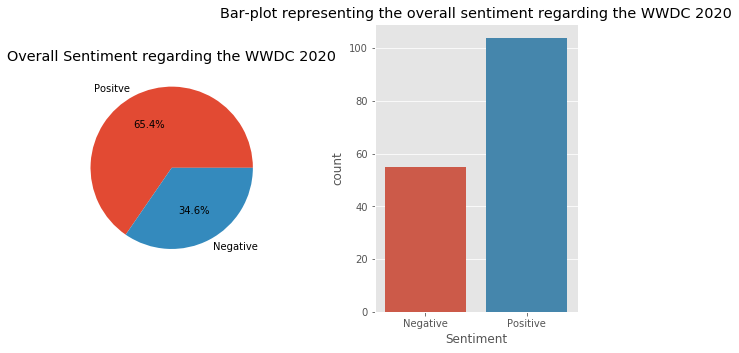

In [37]:
#plotting the overall sentiment for a better visualization
plt.figure(figsize=(20,5))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9,wspace=0.5, hspace=0.2)
plt.style.use('ggplot')

plt.subplot(141)
plt.pie(tweet_df['Sentiment'].value_counts(),labels=['Positve','Negative'],autopct='%1.1f%%')
plt.title('Overall Sentiment regarding the WWDC 2020')

plt.subplot(142)
sns.countplot(tweet_df['Sentiment'])
plt.title('Bar-plot representing the overall sentiment regarding the WWDC 2020')

So as can be seen that there are overall (among the 200 tweets used) more positive tweets (65.4%) about the WWDC in general thus it seems like Apple again has done really well with their conference though it was remote.